In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import os
import struct
import nltk
#nltk.download() 
from nltk.tag import pos_tag # pos_tag shows the characteristic of a word 
                             # using information in the database

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Install Empath tool for analyzing text across lexical categories
import sys
!{sys.executable} -m pip install empath

In [8]:
from empath import Empath

In [9]:
import nltk
# nltk.download('vader_lexicon')

## Part 1 Data Preparation
### 1.1 Data Import

In [10]:
df = pd.read_csv("./data/Combined_News_DJIA.csv", header = 0, index_col = 0)

In [11]:
df.tail()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-27,0,Barclays and RBS shares suspended from trading...,Pope says Church should ask forgiveness from g...,Poland 'shocked' by xenophobic abuse of Poles ...,"There will be no second referendum, cabinet ag...","Scotland welcome to join EU, Merkel ally says",Sterling dips below Friday's 31-year low amid ...,No negative news about South African President...,Surge in Hate Crimes in the U.K. Following U.K...,Weapons shipped into Jordan by the CIA and Sau...,...,German lawyers to probe Erdogan over alleged w...,"Boris Johnson says the UK will continue to ""in...",Richard Branson is calling on the UK governmen...,Turkey 'sorry for downing Russian jet',Edward Snowden lawyer vows new push for pardon...,Brexit opinion poll reveals majority don't wan...,"Conservative MP Leave Campaigner: ""The leave c...","Economists predict UK recession, further weake...","New EU 'superstate plan by France, Germany: Cr...",Pakistani clerics declare transgender marriage...
2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","The personal details of 112,000 French police ...",S&amp;P cuts United Kingdom sovereign credit r...,Huge helium deposit found in Africa,CEO of the South African state broadcaster qui...,"Brexit cost investors $2 trillion, the worst o...",Hong Kong democracy activists call for return ...,Brexit: Iceland president says UK can join 'tr...,UK's Osborne: 'Absolutely' going to have to cu...,...,"US, Canada and Mexico pledge 50% of power from...",There is increasing evidence that Australia is...,"Richard Branson, the founder of Virgin Group, ...","37,000-yr-old skull from Borneo reveals surpri...",Palestinians stone Western Wall worshipers; po...,Jean-Claude Juncker asks Farage: Why are you h...,"""Romanians for Remainians"" offering a new home...",Brexit: Gibraltar in talks with Scotland to st...,8 Suicide Bombers Strike Lebanon,Mexico's security forces routinely use 'sexual...
2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,Iceland historian Johannesson wins presidentia...,...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",The land under Beijing is sinking by as much a...,Car bomb and Anti-Islamic attack on Mosque in ...,Emaciated lions in Taiz Zoo are trapped in blo...,Rupert Murdoch describes Brexit as 'wonderful'...,More than 40 killed in Yemen suicide attacks,Google Found Disastrous Symantec and Norton Vu...,Extremist violence on the rise in Germany: Dom...,BBC News: Labour MPs pass Corbyn no-confidence...,Tiny New Zealand town with 'too many jobs' lau...
2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,Afghan suicide bomber 'kills up to 40' - BBC News,...,Googles free wifi at Indian railway stations i...,Mounting evidence suggests 'hobbits' were wipe...,The men who carried out Tuesday's terror attac...,Calls to suspend Saudi Arabia from UN Human Ri...,More Than 100 Nobel Laureates Call Out Greenpe...,British pedophile sentenced to 85 years in US ...,"US permitted 1,200 offshore fracks in Gulf of ...",We will be swimming in ridicule - French beach...,UEFA says no minutes of silence for Istanbul v...,Law Enforcement Sources: Gun Used in Paris Ter...
2016-07-01,1,A 117-year-old woman 

In [12]:
df.shape

(1989, 26)

In [13]:
df.iloc[0,1]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"'

### 1.2 Data Preparation - Tokenization

In [14]:
stop_words = []
f = open('./data/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words
# The list "stop_words" has 668 words in it

In [15]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    import re
    text = str(text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaobowen39\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gaobowen39\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
def tokenizer(text):
    from functools import reduce
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [18]:
# tokenize each headline in df
for top in df.columns[1:]:
    df[top] = df[top].map(lambda d: tokenizer(d))

In [19]:
import pickle
with open('tokenized_df','wb') as f:
    pickle.dump(df,f)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"[georgia, owns, russian, warplanes, countries,...","[breaking, musharraf, impeached]","[russia, today, columns, troops, roll, south, ...","[russian, tanks, moving, capital, south, osset...","[afghan, children, raped, impunity, official, ...","[russian, tanks, entered, south, ossetia, whil...","[breaking, georgia, invades, south, ossetia, r...","[enemy, combatent, trials, sham, salim, haman,...","[georgian, troops, retreat, osettain, capital,...",...,"[georgia, invades, south, ossetia, russia, inv...","[al, qaeda, faces, islamist, backlash]","[condoleezza, rice, prevent, israeli, strike, ...","[busy, day, european, union, approved, sanctio...","[georgia, withdraw, soldiers, iraq, help, figh...","[pentagon, thinks, attacking, iran, bad, idea,...","[caucasus, crisis, georgia, invades, south, os...","[indian, shoe, manufactory, series, work]","[visitors, suffering, mental, illnesses, banne...","[help, mexico, kidnapping, surge]"
2008-08-11,1,"[america, nato, help, help, help, iraq]","[bush, puts, foot, georgian, conflict]","[jewish, georgian, minister, israeli, training...","[georgian, army, flees, disarray, russians, ad...","[olympic, opening, ceremony, fireworks, faked]","[mossad, fraudulent, zealand, passports, iraq]","[russia, angered, israeli, military, sale, geo...","[american, citizen, living, ossetia, blames, g...","[war, iv, high, definition]",...,"[israel, georgian, aggression]","[tv, russian, georgian, victims]","[riots, going, montreal, canada, police, murde...","[china, overtake, largest, manufacturer]","[war, south, ossetia, pics]","[israeli, physicians, group, condemns, state, ...","[russia, beaten, united, states, head, peak, oil]","[question, georgia, russia, conflict]","[russia, better, war]","[trading, sex, food]"
2008-08-12,0,"[member, adorable, year, sang, opening, ceremo...","[russia, ends, georgia, operation]","[sexual, harassment, children]","[al, qa, eda, losing, support, iraq, brutal, c...","[ceasefire, georgia, putin, outmaneuvers, west]","[microsoft, intel, kill, xo, laptop]","[tratfor, russo, georgian, war, balance, power]","[sense, georgia, russia, war, vote, georgia, s...","[military, surprised, timing, swiftness, russi...",...,"[troops, georgia, georgia, place]","[russias, response, georgia]","[gorbachev, accuses, making, serious, blunder,...","[russia, georgia, nato, cold, war]","[member, adorable, year, led, country, war, ba...","[war, georgia, israeli, connection]","[signs, point, encouraging, georgia, invade, s...","[christopher, king, argues, nato, georgian, in...","[america, mexico]","[bbc, news, asia, pacific, extinction, man, cl..."
2008-08-13,0,"[refuses, israel, weapons, attack, iran, report]","[president, ordered, attack, tskhinvali, capit...","[israel, clears, troops, killed, reuters, came...","[britain, policy, tough, drugs, pointless, civ...","[body, year, trunk, latest, ransom, paid, kidn...","[china, moved, quake, survivors, prefab, homes]","[bush, announces, operation, russia, grill, ye...","[russian, forces, sink, georgian, ships]","[commander, navy, air, reconnaissance, squadro...",...,"[elephants, extinct]","[humanitarian, missions, georgia, russia, hits...","[georgia, ddos, sources]","[russian, convoy, heads, georgia, violating, t...","[israeli, defence, minister, strike, iran]","[gorbachev, choice]","[witness, russian, forces, head, tbilisi, brea...","[quarter, russians, blame, conflict, poll]","[georgian, president, military, control, seapo...","[nobel, laureate, aleksander, solzhenitsyn, ac..."
2008-08-14,1,"[experts, admit, legalise, drugs]","[war, south, osetia, pictures, russian, soldier]","[wedish, wrestler, ara, abrahamian, throws, me...","[russia, exaggerated, death, toll, south, osse...","[missile, killed, inside, pakistan, launched, ...","[rushdie, condemns, random, house, refusal, pu...","[poland, agree, missle, d

In [25]:
with open('tokenized_df','rb') as f:
    tokenized_df = pickle.load(f)
tokenized_df.head()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"[georgia, owns, russian, warplanes, countries,...","[breaking, musharraf, impeached]","[russia, today, columns, troops, roll, south, ...","[russian, tanks, moving, capital, south, osset...","[afghan, children, raped, impunity, official, ...","[russian, tanks, entered, south, ossetia, whil...","[breaking, georgia, invades, south, ossetia, r...","[enemy, combatent, trials, sham, salim, haman,...","[georgian, troops, retreat, osettain, capital,...",...,"[georgia, invades, south, ossetia, russia, inv...","[al, qaeda, faces, islamist, backlash]","[condoleezza, rice, prevent, israeli, strike, ...","[busy, day, european, union, approved, sanctio...","[georgia, withdraw, soldiers, iraq, help, figh...","[pentagon, thinks, attacking, iran, bad, idea,...","[caucasus, crisis, georgia, invades, south, os...","[indian, shoe, manufactory, series, work]","[visitors, suffering, mental, illnesses, banne...","[help, mexico, kidnapping, surge]"
2008-08-11,1,"[america, nato, help, help, help, iraq]","[bush, puts, foot, georgian, conflict]","[jewish, georgian, minister, israeli, training...","[georgian, army, flees, disarray, russians, ad...","[olympic, opening, ceremony, fireworks, faked]","[mossad, fraudulent, zealand, passports, iraq]","[russia, angered, israeli, military, sale, geo...","[american, citizen, living, ossetia, blames, g...","[war, iv, high, definition]",...,"[israel, georgian, aggression]","[tv, russian, georgian, victims]","[riots, going, montreal, canada, police, murde...","[china, overtake, largest, manufacturer]","[war, south, ossetia, pics]","[israeli, physicians, group, condemns, state, ...","[russia, beaten, united, states, head, peak, oil]","[question, georgia, russia, conflict]","[russia, better, war]","[trading, sex, food]"
2008-08-12,0,"[member, adorable, year, sang, opening, ceremo...","[russia, ends, georgia, operation]","[sexual, harassment, children]","[al, qa, eda, losing, support, iraq, brutal, c...","[ceasefire, georgia, putin, outmaneuvers, west]","[microsoft, intel, kill, xo, laptop]","[tratfor, russo, georgian, war, balance, power]","[sense, georgia, russia, war, vote, georgia, s...","[military, surprised, timing, swiftness, russi...",...,"[troops, georgia, georgia, place]","[russias, response, georgia]","[gorbachev, accuses, making, serious, blunder,...","[russia, georgia, nato, cold, war]","[member, adorable, year, led, country, war, ba...","[war, georgia, israeli, connection]","[signs, point, encouraging, georgia, invade, s...","[christopher, king, argues, nato, georgian, in...","[america, mexico]","[bbc, news, asia, pacific, extinction, man, cl..."
2008-08-13,0,"[refuses, israel, weapons, attack, iran, report]","[president, ordered, attack, tskhinvali, capit...","[israel, clears, troops, killed, reuters, came...","[britain, policy, tough, drugs, pointless, civ...","[body, year, trunk, latest, ransom, paid, kidn...","[china, moved, quake, survivors, prefab, homes]","[bush, announces, operation, russia, grill, ye...","[russian, forces, sink, georgian, ships]","[commander, navy, air, reconnaissance, squadro...",...,"[elephants, extinct]","[humanitarian, missions, georgia, russia, hits...","[georgia, ddos, sources]","[russian, convoy, heads, georgia, violating, t...","[israeli, defence, minister, strike, iran]","[gorbachev, choice]","[witness, russian, forces, head, tbilisi, brea...","[quarter, russians, blame, conflict, poll]","[georgian, president, military, control, seapo...","[nobel, laureate, aleksander, solzhenitsyn, ac..."
2008-08-14,1,"[experts, admit, legalise, drugs]","[war, south, osetia, pictures, russian, soldier]","[wedish, wrestler, ara, abrahamian, throws, me...","[russia, exaggerated, death, toll, south, osse...","[missile, killed, inside, pakistan, launched, ...","[rushdie, condemns, random, house, refusal, pu...","[poland, agree, missle, d

## Part 2 Filter headlines by topic

### 2.1 Use Empath to filter headlines 

In [20]:
from empath import Empath
lexicon = Empath()

In [26]:
for i in range(tokenized_df.shape[0]):
    for j in range(1, tokenized_df.shape[1]):
        if tokenized_df.iloc[i, j]:
            topic_scores = lexicon.analyze(' '.join(tokenized_df.iloc[i, j]),\
                                               categories=['economics', 'technology', 'politics'], normalize=True)
            if sum(topic_scores.values()) == 0.:
                tokenized_df.iloc[i, j] = np.NaN
        else:
            tokenized_df.iloc[i, j] = np.NaN

In [27]:
tokenized_df.head()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"[busy, day, european, union, approved, sanctio...",NaN,NaN,NaN,NaN,NaN,NaN
2008-08-11,1,NaN,NaN,NaN,NaN,NaN,NaN,"[russia, angered, israeli, military, sale, geo...","[american, citizen, living, ossetia, blames, g...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trading, sex, food]"
2008-08-12,0,NaN,NaN,NaN,"[al, qa, eda, losing, support, iraq, brutal, c...",NaN,"[microsoft, intel, kill, xo, laptop]",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-13,0,NaN,NaN,NaN,"[britain, policy, tough, drugs, pointless, civ...",NaN,NaN,NaN,NaN,"[commander, navy, air, reconnaissance, squadro...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"[war, caucasus, product, american, imperial, d...",NaN,NaN,NaN,NaN,NaN,NaN,"[philippines, peace, advocate, muslims, assura..."


In [33]:
# check if all top25 headlines are filtered out in each day
sum(tokenized_df.isnull().all(axis = 1))

0

In [34]:
# save filtered dataframe
with open('filtered_tokenized_df', 'wb') as f:
    pickle.dump(tokenized_df, f)

### 2.2 Sentiment Analysis on Headlines Left

In [36]:
with open('filtered_tokenized_df', 'rb') as f:
    filtered_tokenized_df = pickle.load(f)

In [61]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
result = []

for i in range(filtered_tokenized_df.shape[0]):
    compound = []
    neutral =[]
    positive = []
    negative = []
    list_of_headlines = filtered_tokenized_df.iloc[i, :][filtered_tokenized_df.iloc[i, :].notnull()][1:].tolist()
    for headline in list_of_headlines:
        pol_score = sia.polarity_scores(' '.join(headline))
        compound.append(pol_score['compound'])
        neutral.append(pol_score['neu'])
        positive.append(pol_score['pos'])
        negative.append(pol_score['neg'])
    result.append({'compound': np.mean(compound), 'neu': np.mean(neutral), 'pos': np.mean(positive), 'neg': np.mean(negative)})

In [66]:
sentiment_score_df = pd.DataFrame.from_records(result)
sentiment_score_df.set_index(filtered_tokenized_df.index, inplace=True)

In [68]:
sentiment_score_df['Label'] = filtered_tokenized_df['Label']

In [69]:
sentiment_score_df.head()

,compound,neg,neu,pos,Label
Date,,,,,
2008-08-08,0.20230,0.15600,0.62500,0.21900,0
2008-08-11,-0.14695,0.15100,0.80325,0.04575,1
2008-08-12,-0.65160,0.43400,0.49950,0.06600,0
2008-08-13,-0.13415,0.23475,0.67050,0.09450,0
2008-08-14,0.03240,0.17375,0.60600,0.22025,1


In [71]:
with open('sentiment_score_df', 'wb') as f:
    pickle.dump(sentiment_score_df, f)

## Part 3 Vocabulary Construction

In [194]:
# input of this part: the training set
headlines = df.as_matrix(columns = df.columns[1:])
headlines_vocabulary = headlines[:1500]

In [169]:
# Single words that we think may be meaningful.
good_pos_tag_set = set(['JJ','JJR','JJS', # adjective
                        'NN','NNP','NNS','NNPS', # noun
                        'RB','RBR','RBS','RP', # adverb and particle
                        'VB','VBD','VBG','VBN','VBP','VBZ']) # verb

In [170]:
# The following two functions are used to help extract terminology and meaningful words
# REFERENCE: http://bdewilde.github.io/blog/2014/09/23/intro-to-automatic-keyphrase-extraction/
def extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize, POS-tag, and chunk using regular expressions
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent))
                                                    for tagged_sent in tagged_sents))
    # join constituent chunk words into a single chunked phrase
    candidates = [' '.join(word for word, pos, chunk in group).lower()
                  for key, group in itertools.groupby(all_chunks, lambda (word,pos,chunk): chunk != 'O') if key]

    return [cand for cand in candidates
            if cand not in stop_words and not all(char in punct for char in cand)]

In [171]:
headlines_vocabulary

array([[ ['georgia', 'owns', 'russian', 'warplanes', 'countries', 'move', 'brink', 'war'],
        ['breaking', 'musharraf', 'impeached'],
        ['russia', 'today', 'columns', 'troops', 'roll', 'south', 'ossetia', 'footage', 'fighting', 'youtube'],
        ..., ['indian', 'shoe', 'manufactory', 'series', 'work'],
        ['visitors', 'suffering', 'mental', 'illnesses', 'banned', 'olympics'],
        ['help', 'mexico', 'kidnapping', 'surge']],
       [['america', 'nato', 'help', 'help', 'help', 'iraq'],
        ['bush', 'puts', 'foot', 'georgian', 'conflict'],
        ['jewish', 'georgian', 'minister', 'israeli', 'training', 'fending', 'russia'],
        ..., ['question', 'georgia', 'russia', 'conflict'],
        ['russia', 'better', 'war'], ['trading', 'sex', 'food']],
       [['member', 'adorable', 'year', 'sang', 'opening', 'ceremonies', 'fake'],
        ['russia', 'ends', 'georgia', 'operation'],
        ['sexual', 'harassment', 'children'], ...,
        ['christopher', 'king', 'a

In [172]:
'''
Input a string, output its vocabulary list
'''
def buildVocabulary(OrderedWord):
    String = ' '.join(OrderedWord)
    word_candidate = OrderedWord
    word_final = []
    for i in range(len(word_candidate)):
        posTag = pos_tag([str(word_candidate[i])])[0][1]
        isGood = (good_pos_tag_set.union([posTag])==good_pos_tag_set)
        if isGood:
            word_final.append(str(word_candidate[i]))
    phase_final = extract_candidate_chunks(String, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}')
    term_final = word_final+phase_final
    return term_final

buildVocabulary(["I","have","a","great","apple","and","big","peach"])

['have', 'great', 'apple', 'big', 'peach', 'great apple', 'big peach']

In [176]:
vocabulary = []
for i in range(len(headlines_vocabulary)):
    for s in headlines_vocabulary[i]:
        vocabulary = vocabulary + buildVocabulary(s)
    if (i%15==0):
        print i/15

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [177]:
len(vocabulary)

483013

In [178]:
with open('vocabulary','wb') as v:
    pickle.dump(vocabulary,v)
with open('vocabulary','rb') as v:
    vocabulary = pickle.load(v)
vocabulary

['georgia',
 'owns',
 'russian',
 'warplanes',
 'countries',
 'move',
 'brink',
 'war',
 'georgia',
 'russian warplanes countries',
 'brink war',
 'breaking',
 'musharraf',
 'impeached',
 'musharraf',
 'russia',
 'today',
 'columns',
 'troops',
 'roll',
 'south',
 'ossetia',
 'footage',
 'fighting',
 'youtube',
 'russia today',
 'troops',
 'south ossetia footage',
 'youtube',
 'russian',
 'tanks',
 'moving',
 'capital',
 'south',
 'ossetia',
 'reportedly',
 'completely',
 'destroyed',
 'georgian',
 'artillery',
 'fire',
 'russian tanks',
 'capital',
 'destroyed georgian artillery fire',
 'afghan',
 'children',
 'raped',
 'impunity',
 'official',
 'sick',
 'year',
 'raped',
 'afghan children',
 'impunity official',
 'year',
 'russian',
 'tanks',
 'entered',
 'south',
 'ossetia',
 'whilst',
 'georgia',
 'shoots',
 'russian',
 'jets',
 'russian tanks',
 'south ossetia whilst georgia shoots russian jets',
 'breaking',
 'georgia',
 'invades',
 'south',
 'ossetia',
 'russia',
 'warned',
 'in

In [179]:
final_vocabulary = set(vocabulary)

In [214]:
len(final_vocabulary)

98791

In [229]:
final_vocabulary

{'bp reports quarterly profit',
 'computer hacker',
 'anonymous threatens',
 'russia syria',
 'price gold',
 'imf loan haiti interest free good haiti grants loans',
 'woods',
 'spiders',
 'israeli ultra orthodox jews clash police',
 'hanging',
 'woody',
 'trawling',
 'overissuance',
 'trapped cars',
 'action woman',
 'iranian film separation',
 'sexual assault',
 'caned',
 'cold blood international outrage demonstrations',
 'mote villages',
 'greek elections leader victory march',
 'gates donates',
 'mea culpa imfs chief economist austerity',
 'captive chinese plant workers',
 'pigment',
 'assistance nordic countries hip',
 'lamido',
 'replaces',
 'estonian man',
 'online poker billionaire dikshit',
 'bringing',
 'intruduced',
 'protection state bill',
 'dollar cup iran',
 'magical ability eyes',
 'grueling',
 'vibrational',
 'wooden',
 'substantial convoy troops military vehicles',
 'wednesday',
 'virtuosos',
 'israeli sanctions',
 'floor canadian senate',
 'schools election program g

In [239]:
final_vocabulary_s = []
c = 0
for term in final_vocabulary:
    if (len(term.split())<3):
        final_vocabulary_s.append(term)
    if (len(term.split())==2):
        c = c+1
print len(final_vocabulary_s)
print c
final_vocabulary_s

52256
22712


['computer hacker',
 'anonymous threatens',
 'russia syria',
 'price gold',
 'woods',
 'spiders',
 'hanging',
 'woody',
 'trawling',
 'overissuance',
 'trapped cars',
 'action woman',
 'sexual assault',
 'caned',
 'mote villages',
 'gates donates',
 'pigment',
 'lamido',
 'replaces',
 'estonian man',
 'bringing',
 'intruduced',
 'grueling',
 'vibrational',
 'wooden',
 'wednesday',
 'virtuosos',
 'israeli sanctions',
 'bbqs',
 'ground searches',
 'ghost airports',
 'uality',
 'errors',
 'warmongering',
 'designing',
 'entire crew',
 'disobeying',
 'brainwashed',
 'british mp',
 'cable leaks',
 'demonstrators custody',
 'egrading',
 'wagyu',
 'affiliated',
 'iranian government',
 'kids',
 'responsibility disaster',
 'blowpipes',
 'controversy',
 'construction workers',
 'greek state',
 'stand guangzhou',
 'toowoomba',
 'american freedom',
 'projection',
 'censoship policy',
 'wild camels',
 'company hq',
 'flex muscles',
 'stern',
 'russian skinheads',
 'china freaks',
 'dnd',
 'agassi',

## Part 4 Input Matrix for Models

In [210]:
for top in df.columns[1:]:
    df[top] = df[top].map(lambda d: ' '.join(d))
headlines = df.as_matrix(columns = df.columns[1:])
headlines

array([['georgia owns russian warplanes countries move brink war',
        'breaking musharraf impeached',
        'russia today columns troops roll south ossetia footage fighting youtube',
        ..., 'indian shoe manufactory series work',
        'visitors suffering mental illnesses banned olympics',
        'help mexico kidnapping surge'],
       ['america nato help help help iraq',
        'bush puts foot georgian conflict',
        'jewish georgian minister israeli training fending russia', ...,
        'question georgia russia conflict', 'russia better war',
        'trading sex food'],
       ['member adorable year sang opening ceremonies fake',
        'russia ends georgia operation', 'sexual harassment children', ...,
        'christopher king argues nato georgian invasion south ossetia misjudged russian resolve',
        'america mexico', 'bbc news asia pacific extinction man climate'],
       ..., 
       ['explosion airport istanbul',
        'yemeni president terrorism of

In [211]:
headlines =[' '.join(map(str, headline)) for headline in headlines]
headlines

['georgia owns russian warplanes countries move brink war breaking musharraf impeached russia today columns troops roll south ossetia footage fighting youtube russian tanks moving capital south ossetia reportedly completely destroyed georgian artillery fire afghan children raped impunity official sick three year raped russian tanks entered south ossetia whilst georgia shoots russian jets breaking georgia invades south ossetia russia warned intervene side enemy combatent trials sham salim haman sentenced years longer feel georgian troops retreat osettain capital presumably leaving people killed video prep georgia war russia rice green light israel attack iran veto israeli military ops announcing class action lawsuit behalf american public fbi russia georgia war nyt top story opening ceremonies olympics fucking disgrace proof decline journalism china tells bush stay countries affairs war iii start today georgia invades south ossetia russia involved nato absorb georgia unleash full scale 

In [212]:
headlines_train = headlines[:1500]
headlines_test = headlines[1500:]
DJIA_train = df.Label[:1500].values
DJIA_test = df.Label[1500:].values

In [240]:
tfidfvectorizer_final = TfidfVectorizer(min_df=0.03, max_df=0.97, vocabulary=final_vocabulary_s, ngram_range=(1, 5))
train_term_document_matrix_tfidf = tfidfvectorizer_final.fit_transform(headlines_train)
test_term_document_matrix_tfidf = tfidfvectorizer_final.transform(headlines_test)
print train_term_document_matrix_tfidf.shape
print test_term_document_matrix_tfidf.shape

(1500, 52256)
(489, 52256)


## Part 6 Prediction Models
### Prediction Models - KNN

In [241]:
def KNN(X_train, Y_train, X_test, Y_test, K):
    """
    X_train: term_doc_matrix
    Y_train: list
    X_test: term_doc_matrix
    Y_test: list
    K: integer
    """
    pred_train = np.zeros(len(Y_train), dtype = 'int64')
    pred_test = np.zeros(len(Y_test), dtype = 'int64')
    inverted_index_test = { i[0]:i[1] for i in list(zip(range(len(Y_test)),Y_test))}
    inverted_index_train= { i[0]:i[1] for i in list(zip(range(len(Y_train)),Y_train))}
    sim_score_matrix_K_train = cosine_similarity(X_train, X_train)
    for j in range(sim_score_matrix_K_train.shape[0]):
        highest_K_score_index_train = np.argsort(sim_score_matrix_K_train[j])[-K:]
        DJIA_K_train = [inverted_index_train[idx] for idx in highest_K_score_index_train]
        Prob = (sum(DJIA_K_train)+0.)/len(DJIA_K_train) #smoothing
        if Prob >= 0.5:
            pred_train[j] = 1
        else:
            pred_train[j] = 0
    sim_score_matrix_K =  cosine_similarity(X_test, X_train)
    for j in range(sim_score_matrix_K.shape[0]):
        highest_K_score_index = np.argsort(sim_score_matrix_K[j])[-K:]
        DJIA_K = [inverted_index_train[idx] for idx in highest_K_score_index]
        Prob = (sum(DJIA_K)+0.)/len(DJIA_K) #smoothing
        if Prob >= 0.5:
            pred_test[j] = 1
        else:
            pred_test[j] = 0
    accu_train = np.mean(Y_train == pred_train)        
    accu_test = np.mean(Y_test == pred_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
Knn = KNN(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test,10)
print "KNN Model, K = 10"
print "Training Error:\t",Knn[0]
print "Test Error:\t",Knn[1]

KNN Model, K = 10
Training Error:	0.386
Test Error:	0.509202453988


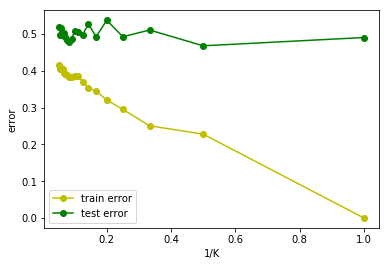

In [242]:
train_error =[KNN(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, K)[0] for K in range(1, 20)]
test_error = [KNN(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, K)[1] for K in range(1, 20)]
one_over_k = [1.0/K for K in range(1, 20)]
plt.plot(one_over_k, train_error, '-yo', label = 'train error')
plt.plot(one_over_k, test_error, '-go', label = 'test error')
plt.ylabel('error')
plt.xlabel('1/K')
plt.legend(loc = 'lower left')

In [243]:
KNN(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, 10)

(0.38600000000000001, 0.50920245398773001)

In [244]:
np.argmin(test_error)

1

### Prediction Models - Logistic

In [245]:
from sklearn.linear_model import LogisticRegression
def Logit(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression()
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
Logit0 = Logit(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Logistic Model"
print "Training Error:\t",Logit0[0]
print "Test Error:\t",Logit0[1]

Logistic Model
Training Error:	0.0186666666667
Test Error:	0.496932515337


In [246]:
def LogitLasso(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression(penalty='l1')
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
LogitL = LogitLasso(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Logistic Lasso Model"
print "Training Error:\t",LogitL[0]
print "Test Error:\t",LogitL[1]

Logistic Lasso Model
Training Error:	0.458
Test Error:	0.482617586912


In [247]:
def LogitRidge(X_train, Y_train, X_test, Y_test):
    logit = LogisticRegression(penalty='l2')
    logit_fit = logit.fit(X_train, Y_train)
    logit_train_predict = logit.predict(X_train)
    logit_predict = logit.predict(X_test)
    accu_train = sum(Y_train == logit_train_predict)/float(len(Y_train))
    accu_test = sum(Y_test == logit_predict)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
LogitR = LogitRidge(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Logistic Ridge Model"
print "Training Error:\t",LogitR[0]
print "Test Error:\t",LogitR[1]

Logistic Ridge Model
Training Error:	0.0186666666667
Test Error:	0.496932515337


### Prediction Models - Rocchio Classification

In [248]:
def Rocchio(X_train, Y_train, X_test, Y_test):
    pred_train = np.zeros(len(Y_train), dtype = 'int64')
    pred_test = np.zeros(len(Y_test), dtype = 'int64')
    X_train_1 = X_train[np.array(Y_train) == 1, :]
    X_train_0 = X_train[np.array(Y_train) == 0, :]
    Centriod_1 = (np.sum(X_train_1, axis = 0)+0.)/X_train_1.shape[0]
    Centriod_0 = (np.sum(X_train_0, axis = 0)+0.)/X_train_0.shape[0]
    for j in range(len(Y_train)):
        distance_1 = np.sqrt(np.sum(np.square(X_train[j]-Centriod_1)))
        distance_0 = np.sqrt(np.sum(np.square(X_train[j]-Centriod_0)))
        if distance_1 <= distance_0:
            pred_train[j] = 1
        else:
            pred_train[j] = 0
    accu_train = np.mean(Y_train == pred_train)
    for j in range(len(Y_test)):
        distance_1 = np.sqrt(np.sum(np.square(X_test[j]-Centriod_1)))
        distance_0 = np.sqrt(np.sum(np.square(X_test[j]-Centriod_0)))
        if distance_1 <= distance_0:
            pred_test[j] = 1
        else:
            pred_test[j] = 0
    accu_test = np.mean(Y_test == pred_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
Rocchio = Rocchio(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Rocchio Classification Model"
print "Training Error:\t",Rocchio[0]
print "Test Error:\t",Rocchio[1]

Rocchio Classification Model
Training Error:	0.0113333333333
Test Error:	0.509202453988


### Prediction Models - Naive Bayes

In [249]:
from sklearn.naive_bayes import BernoulliNB
def NaiveBayes(X_train, Y_train, X_test, Y_test):
    BNBclassifier = BernoulliNB(alpha=1)
    BNBclassifier.fit(X_train, Y_train)
    BNBpred_train = BNBclassifier.predict(X_train)
    BNBpred = BNBclassifier.predict(X_test)
    accu_train = np.mean(BNBpred_train==Y_train)
    accu_test = np.mean(BNBpred==Y_test)
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
NBayes = NaiveBayes(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Naive Bayes Model"
print "Training Error:\t",NBayes[0]
print "Test Error:\t",NBayes[1]

Naive Bayes Model
Training Error:	0.0
Test Error:	0.513292433538


### Prediction Models - Decision Tree

In [250]:
# REFERENCE: http://scikit-learn.org/stable/modules/tree.html
from sklearn import tree
def DecisionTree(X_train, Y_train, X_test, Y_test):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, Y_train)
    clf_train = clf.predict(X_train)
    clf_test = clf.predict(X_test)
    accu_train = sum(Y_train == clf_train)/float(len(Y_train))
    accu_test = sum(Y_test == clf_test)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
DTree = DecisionTree(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test)
print "Decision Tree Model"
print "Training Error:\t",DTree[0]
print "Test Error:\t",DTree[1]

Decision Tree Model
Training Error:	0.0
Test Error:	0.531697341513


### Prediction Models - Random Forests

In [251]:
# REFERENCE: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
def RandomForest(X_train, Y_train, X_test, Y_test, md):
    clfr = RandomForestClassifier(max_depth=md, random_state=0)
    clfr = clfr.fit(X_train, Y_train)
    clfr_train = clfr.predict(X_train)
    clfr_test = clfr.predict(X_test)
    accu_train = sum(Y_train == clfr_train)/float(len(Y_train))
    accu_test = sum(Y_test == clfr_test)/float(len(Y_test))
    error_train = 1.0-accu_train
    error_test = 1.0-accu_test
    return error_train,error_test
RF = RandomForest(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, 10)
print "Random Forests Model, max_depth = 10"
print "Training Error:\t",RF[0]
print "Test Error:\t",RF[1]

Random Forests Model, max_depth = 10
Training Error:	0.260666666667
Test Error:	0.472392638037


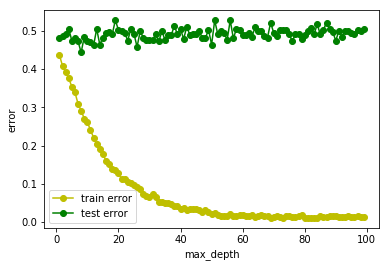

In [252]:
train_error =[RandomForest(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, md)[0] for md in range(1, 100)]
test_error = [RandomForest(train_term_document_matrix_tfidf, DJIA_train, test_term_document_matrix_tfidf, DJIA_test, md)[1] for md in range(1, 100)]
md_order = range(1,100)
plt.plot(md_order, train_error, '-yo', label = 'train error')
plt.plot(md_order, test_error, '-go', label = 'test error')
plt.ylabel('error')
plt.xlabel('max_depth')
plt.legend(loc = 'lower left')